In [1]:
'''
Physical changes case study for paper
'''

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import glob
from contextlib import contextmanager
from matplotlib.colors import ListedColormap, BoundaryNorm
@contextmanager
def cd(newdir):
    prevdir = os.getcwd()
    os.chdir(newdir)
    try:
        yield
    finally:
        os.chdir(prevdir)

model_path = '/edata2/spencer/rfi_prediction/SSMI/F13/'

with cd(model_path):
    import local_functions
    import model_operations
    import sensor_info

nchans = sensor_info.nchannels
chan_desc = sensor_info.channel_descriptions

In [2]:
def get_prediction_error(lat, lon, Tbs, scantime, modelpath, sensor):
    
    good = ~np.isnan(lat)

    nscans, npixs, nchans = Tbs.shape
    scantime = local_functions.copy_columns(scantime, npixs)

    with cd(modelpath):
        #Load in model tree
        model_tree = model_operations.load_model_tree()
        #Attach GPM surface type
        sfctype = np.zeros([nscans,npixs], dtype=np.int32)
        sfctype[:] = -99
        sfctype[good] = local_functions.attach_gpm_sfctype(lat[good], 
                                                           lon[good],
                                                           scantime[good], 
                                                           sensor=sensor)
        #Do Tb prediction
        Tbs_pred = np.zeros_like(Tbs)
        Tbs_pred[:] = np.nan
        Tbs_pred[good] = model_operations.run_predictions(Tbs[good], 
                                                          sfctype[good], 
                                                          model_tree, 
                                                          keep_dims=False)

        #Load in stats files
        mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
        std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
        mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
        std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)

    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    epsilon_hat[:] = np.nan

    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)

    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    
    return epsilon_hat

In [3]:
flist = glob.glob(f'/qdata1/pbrown/transfer/spencer/SSMI_files/F13_*_qc.pkl'); flist.sort()
flist

['/qdata1/pbrown/transfer/spencer/SSMI_files/F13_1995_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_1996_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_1997_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_1998_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_1999_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2000_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2001_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2002_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2003_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2004_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2005_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2006_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2007_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2008_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_200907_qc.pkl',
 '/qdata1/pbrown/transfer/spencer/SSMI_files/F13_2009

In [4]:
import pickle
for i,ifile in enumerate(flist):
    if len(ifile.split('/')[-1].split('_')[1]) > 4: continue
    with open(ifile, 'rb') as f:
        data = pickle.load(f)
    if i == 0:
        datetimes = data['datetimes']
        counts    = data['counts_array']
    else:
        datetimes = np.concatenate((datetimes, data['datetimes']))
        counts    = np.concatenate((counts, data['counts_array']), axis=0)

In [5]:
import datetime

beg_date = '2001-01-01'
end_date = '2002-01-01'

beg_date = np.datetime64(beg_date).astype('datetime64[s]').astype(datetime.datetime)
end_date = np.datetime64(end_date).astype('datetime64[s]').astype(datetime.datetime)

beg_indx = np.where(datetimes >= beg_date)[0][0]
end_indx = np.where(datetimes <= end_date)[0][-1]

In [6]:
#Apply running mean to make plots nicer
import stats
for ichan in range(nchans):
    counts[:,ichan] = stats.running_mean(counts[:,ichan], window_size=18, method='center', ends='wrap')

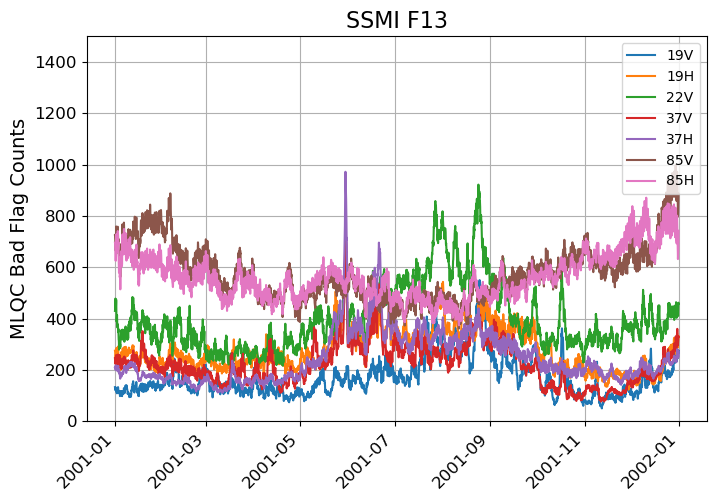

In [7]:
plt.figure(figsize=[8,5])
for ichan in range(nchans):
    if chan_desc[ichan][-1] == 'a': continue
    plt.plot(datetimes[beg_indx:end_indx],counts[beg_indx:end_indx,ichan], 
             linewidth=1.5,
             label=chan_desc[ichan][:3])
#plt.axhline(1500, color='k', linestyle='--')
plt.grid()
plt.ylim(0,1500)
plt.legend(loc='upper right')
plt.ylabel('MLQC Bad Flag Counts', fontsize=14)
plt.title('SSMI F13', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [30]:
flist = glob.glob(f'/edata1/archive/GPM/1C_F13_V7/0108/010801/*.HDF5'); flist.sort()

#file = '/edata1/archive/GPM/1C_F13_V7/0108/010801/1C.F13.SSMI.XCAL2018-V.20010801-S011555-E025748.032785.V07A.HDF5'
mlqcflag = {}
data_all = {}
for i,ifile in enumerate(flist):

    data = local_functions.read_ssmi_l1c(ifile)

    pred_err = get_prediction_error(data['lat'], data['lon'], data['Tbs'], data['scantime'],
                                    modelpath = model_path, sensor='SSMI')
    error_threshold = 4
    mlflag = np.zeros_like(data['Tbs'], dtype=np.int32)
    mlflag[pred_err > error_threshold] = 1
    mlflag[np.isnan(pred_err)] = -2
    mlqcflag[f'mlflag_{i}'] = mlflag
    data_all[f'data_{i}'] = data

In [18]:
# error_threshold = 4
# mlflag = np.zeros_like(data['Tbs'], dtype=np.int32)
# mlflag[pred_err > error_threshold] = 1
# mlflag[np.isnan(pred_err)] = -2

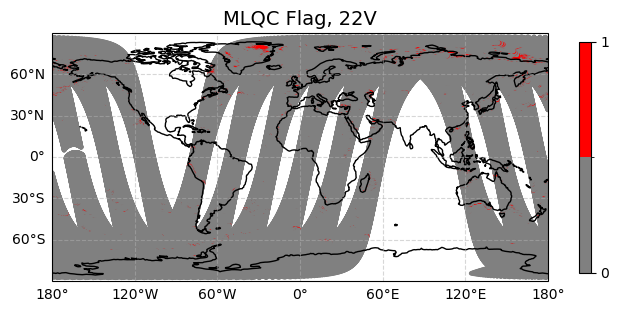

In [39]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

cmap = ListedColormap(["gray", "red"])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

im = ax.scatter(data_all['data_0']['lon'],
                data_all['data_0']['lat'],
                c=mlqcflag['mlflag_0'][:,:,2],
                transform=ccrs.PlateCarree(), 
                s=5, cmap=cmap, norm=norm)

im = ax.scatter(data_all['data_1']['lon'],
                data_all['data_1']['lat'],
                c=mlqcflag['mlflag_1'][:,:,2],
                transform=ccrs.PlateCarree(), 
                s=5, cmap=cmap, norm=norm)

im = ax.scatter(data_all['data_2']['lon'],
                data_all['data_2']['lat'],
                c=mlqcflag['mlflag_2'][:,:,2],
                transform=ccrs.PlateCarree(), 
                s=5, cmap=cmap, norm=norm)

im = ax.scatter(data_all['data_3']['lon'],
                data_all['data_3']['lat'],
                c=mlqcflag['mlflag_3'][:,:,2],
                transform=ccrs.PlateCarree(), 
                s=5, cmap=cmap, norm=norm)

im = ax.scatter(data_all['data_4']['lon'],
                data_all['data_4']['lat'],
                c=mlqcflag['mlflag_4'][:,:,2],
                transform=ccrs.PlateCarree(), 
                s=5, cmap=cmap, norm=norm)

im = ax.scatter(data_all['data_5']['lon'],
                data_all['data_5']['lat'],
                c=mlqcflag['mlflag_5'][:,:,2],
                transform=ccrs.PlateCarree(), 
                s=5, cmap=cmap, norm=norm)

#ax.set_extent([-180,180,30,90])
ax.coastlines()
ax.set_title('MLQC Flag, 22V', fontsize=14)
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cbar = plt.colorbar(im, ticks=[0,1], shrink=0.5)
plt.show()


In [37]:
sensor_info.channel_descriptions

['19V', '19H', '22V', '37V', '37H', '85Va', '85Ha', '85Vb', '85Hb']